# Predicting Internet Speed for US Counties

## Data cleaning

### Internet Speed Data

In [25]:
import os
import requests, zipfile, io
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
crs = 'epsg:4326'

In [2]:
def get_internet_data():
    '''
    Downloads data internet speed data from S3 bucket
    '''
    if not os.path.isdir('./2020-04-01_performance_fixed_tiles'):
        r = requests.get("https://ookla-open-data.s3-us-west-2.amazonaws.com/shapefiles/performance/type%3Dfixed/year%3D2020/quarter%3D2/2020-04-01_performance_fixed_tiles.zip")
        zf = zipfile.ZipFile(io.BytesIO(r.content))
        zf.extractall("2020-04-01_performance_fixed_tiles")
    else:
        print('file already in directory')
    
    df = gpd.read_file("2020-04-01_performance_fixed_tiles/gps_fixed_tiles.shp")
    return df

In [3]:
speed = get_internet_data()
speed.head()

file already in directory


,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,geometry
0,1321222233020202,144116,125751,3,7330,1324,"POLYGON ((113.55469 22.16197, 113.56018 22.161..."
1,1230231303303002,89763,52939,42,726,137,"POLYGON ((55.41504 25.27947, 55.42053 25.27947..."
2,0313131210131030,62657,15479,19,271,40,"POLYGON ((-1.79077 51.55658, -1.78528 51.55658..."
3,0213330110110321,98061,11842,19,2,1,"POLYGON ((-93.22449 45.06576, -93.21899 45.065..."
4,3100130032202231,15167,7287,8,674,122,"POLYGON ((107.59460 -6.91552, 107.60010 -6.915..."


### Counties Polygons

In [4]:
def get_counties_shape():
    '''
    Downloads counties shapedile from U.S Census Bureau
    '''
    county_url = "https://www2.census.gov/geo/tiger/TIGER2019/COUNTY/tl_2019_us_county.zip" 
    counties = gpd.read_file(county_url).to_crs(4326)
    counties = counties.drop(columns=['COUNTYFP','COUNTYNS', 'LSAD','CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP', 'FUNCSTAT', 
                'ALAND','AWATER'])
    return counties

In [5]:
counties = get_counties_shape()
counties.head()

,STATEFP,GEOID,NAME,NAMELSAD,INTPTLAT,INTPTLON,geometry
0,31,31039,Cuming,Cuming County,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,53069,Wahkiakum,Wahkiakum County,+46.2946377,-123.4244583,"POLYGON ((-123.43640 46.23819, -123.44759 46.2..."
2,35,35011,De Baca,De Baca County,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,31109,Lancaster,Lancaster County,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,31129,Nuckolls,Nuckolls County,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


### Merging the Data

In [8]:
def merge_speed_counties(speed_data, counties_data):
    #Merge Speed data with county boundaries
    county_speed = gpd.sjoin(counties_data, speed_data, how="left", op='intersects')
    # convert to Mbps for easier reading
    county_speed['avg_d_mbps'] = county_speed['avg_d_kbps'] / 1000
    county_speed['avg_u_mbps'] = county_speed['avg_u_kbps'] / 1000
    return county_speed

In [9]:
df = merge_speed_counties(speed, counties)

## Aggregate by County

Aggregate the test by county anc count the number of tests in each county

In [13]:
import pandas as pd
import numpy as np

In [14]:
#Aggregate the download speed by the number of test on a county
df_all = (df.groupby(["GEOID", "NAMELSAD"]).apply(
        lambda x: pd.Series(
            {"avg_d_mbps_wt": np.average(x["avg_d_mbps"], weights=x["tests"])})).reset_index()
    .merge(
        df.groupby(["GEOID", "NAMELSAD"]).agg(tests=("tests", "sum")).reset_index(),
        on=["GEOID", "NAMELSAD"]))

In [15]:
df_all.head()

,GEOID,NAMELSAD,avg_d_mbps_wt,tests
0,01001,Autauga County,141.184155,5005.0
1,01003,Baldwin County,102.417593,25047.0
2,01005,Barbour County,65.590938,691.0
3,01007,Bibb County,39.640721,714.0
4,01009,Blount County,62.067675,4748.0


In [52]:
county_speed = df_all.loc[df_all["tests"] >= 50, :]
county_speed.count()

labels = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps", "More than 200 Mbps"]

county_speed['group'] = pd.cut(
    county_speed.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200,530), 
    right=False, 
    labels = labels)
county_speed.head(5)

label2 = [1, 2, 3, 4, 5, 6]

county_speed['group_num'] = pd.cut(
    county_speed.avg_d_mbps_wt, 
    (0, 25, 50, 100, 150, 200,530), 
    right=False, 
    labels = label2)
county_speed.head(5)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,GEOID,NAMELSAD,avg_d_mbps_wt,tests,group,group_num
0,01001,Autauga County,141.184155,5005.0,100 to 150 Mbps,4
1,01003,Baldwin County,102.417593,25047.0,100 to 150 Mbps,4
2,01005,Barbour County,65.590938,691.0,50 to 100 Mbps,3
3,01007,Bibb County,39.640721,714.0,25 to 50 Mbps,2
4,01009,Blount County,62.067675,4748.0,50 to 100 Mbps,3


### Map

In [85]:
county_data = counties[['GEOID', 'geometry', 'NAME', 'STATEFP']].merge(county_speed, on='GEOID', how='left').to_crs(26916)
#We will work just with USA continental
county_data = county_data[(county_data.STATEFP != '02') & (county_data.STATEFP  != '15')
                              & (county_data.STATEFP  != '69') & (county_data.STATEFP  != '78')
                             & (county_data.STATEFP  != '66') & (county_data.STATEFP  != '60') 
                          & (county_data.STATEFP  != '72')]
county_data['STATEFP'].nunique()

49

In [86]:
county_data.count()

GEOID            3108
geometry         3108
NAME             3108
STATEFP          3108
NAMELSAD         3011
avg_d_mbps_wt    3011
tests            3011
group            3011
group_num        3011
dtype: int64

(-2969748.062021963, 2331634.8865646683, 2537930.7192537906, 6269757.003164073)

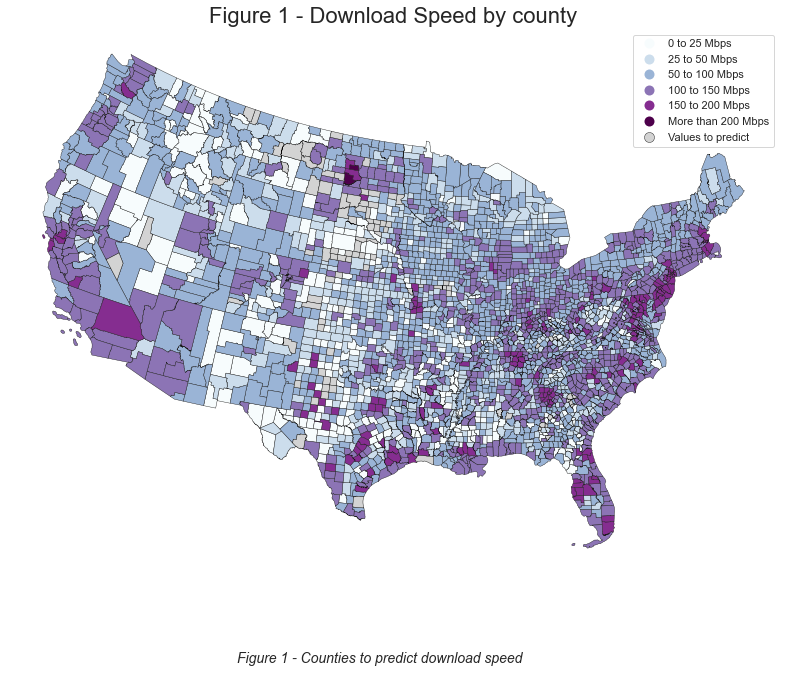

In [87]:
county_data = county_data.sort_values(by='group_num')
#Plot the number of crimes on the map
sns.set(rc={'figure.figsize':(15, 10)})
sns.set_style("white")
fig,ax = plt.subplots()
county_data.plot(column='group_num', ax=ax, legend=True, categorical=True, cmap='BuPu', linewidth=0.4, edgecolor="0.1", 
               missing_kwds={"color": "lightgray","edgecolor": "black", "label": "Values to predict"})
# Set labels and titles.
plt.title('Figure 1 - Download Speed by county', fontsize=22)
txt= "Figure 1 - Counties to predict download speed"
plt.figtext(0.5, 0,s=txt, ha='center', fontsize=14, style='italic')
leg = ax.get_legend()
leg.get_texts()[0].set_text("0 to 25 Mbps")
leg.get_texts()[1].set_text("25 to 50 Mbps")
leg.get_texts()[2].set_text("50 to 100 Mbps")
leg.get_texts()[3].set_text("100 to 150 Mbps")
leg.get_texts()[4].set_text("150 to 200 Mbps")
leg.get_texts()[5].set_text("More than 200 Mbps")
ax.axis("off")